In [1]:
%%capture
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import kendalltau
import numpy as np

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['figure.dpi'] = 300

In [2]:
df6 = pd.read_csv("MI_Gaussian_grids.csv", index_col=0)
df6 = df6.replace(np.nan, 0)
df4 = df6[df6['Estimator'].isin(['LMI',
                                 'MINE',
                                 'InfoNCE',
                                 'KSG'])]

c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
c4 = [c6[c] for c in range(6) if c in [1,2,3,5]]

g6 = df6.groupby(['Ambient dimensions', 'Intrinsic dimensions', 'Estimator'])
g4 = df4.groupby(['Ambient dimensions', 'Intrinsic dimensions', 'Estimator'])

def kendall(group):
    t = group['True MI']
    e = group['Estimate']
    return kendalltau(t, e)[0]

def mse(group):
    t = group['True MI']
    e = group['Estimate']
    return np.mean(np.abs(t-e)**2)

def letter_annotation(ax, xoffset, yoffset, letter):
     ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
             size=20, weight='bold')

/tmp/ipykernel_228427/1081938565.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])
/tmp/ipykernel_228427/1081938565.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


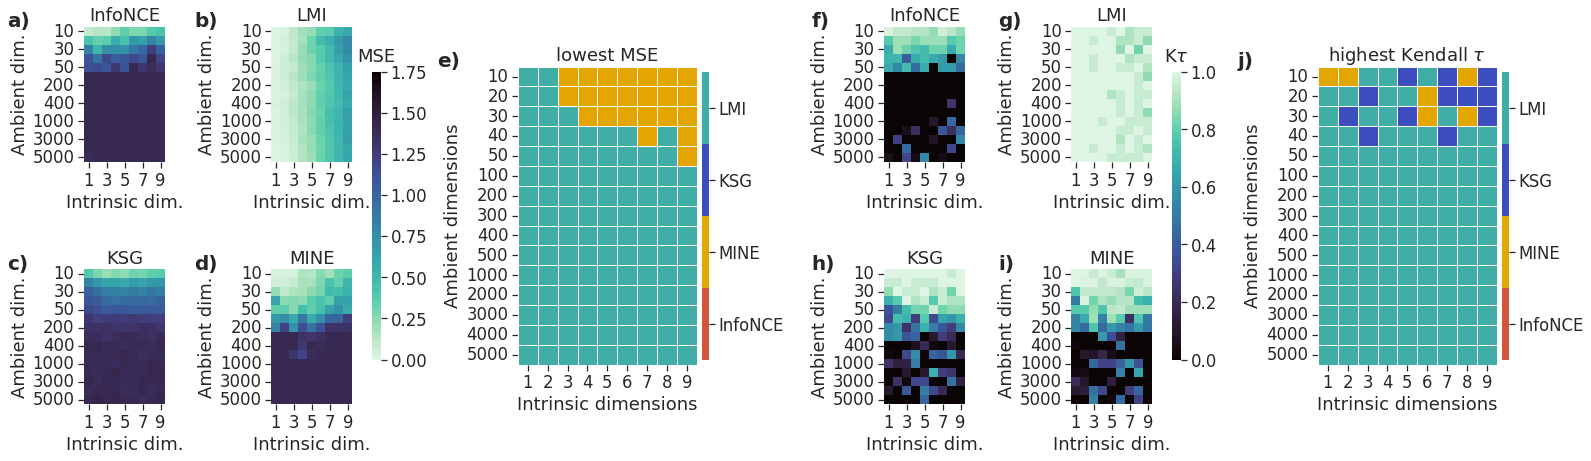

In [3]:
fig = plt.figure(figsize=(20, 10))

mse_half, kendall_half = fig.subfigures(1, 2, wspace=.25)

mse_vals, mse_bests = mse_half.subfigures(1, 2, wspace=.5, 
                                          width_ratios=(3,2))

kendall_vals, kendall_bests = kendall_half.subfigures(1, 2, wspace=.5, 
                                          width_ratios=(3,2))
sns.set(font_scale=1.5)
###################################
###### MSE values 4 heatmaps ######
###################################

axn = mse_vals.subplots(2, 2)
cbar_ax = mse_vals.add_axes([.95, .3, .03, .4])

k = g4.apply(mse).unstack().fillna(0)
ests = list(set(df4['Estimator']))
letters = ['a)', 'b)', 'c)', 'd)']
for i, ax in enumerate(axn.flat):
    sns.heatmap(k.reset_index().pivot_table(index='Ambient dimensions',
                            columns='Intrinsic dimensions',
                            values=ests[i]), square=True, cmap='mako_r',
                ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1.75, #linewidth=0.05,
                cbar_ax=None if i else cbar_ax,
                yticklabels=2)
    if not i:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_title('MSE', pad=10)
        
    ax.set_title(ests[i])
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    letter_annotation(ax, -.95, 1, letters[i])
    ax.set_xlabel('Intrinsic dim.')
    ax.set_ylabel('Ambient dim.')

fig.tight_layout(rect=[0, 0, .9, 1])


###############################
###### MSE bests heatmap ######
###############################

value_to_int = {j:i for i,j in enumerate(pd.unique(df4['Estimator'].values.ravel()))}
value_to_int
n = len(value_to_int)     

bests = k.melt(ignore_index=False).reset_index().sort_values(
    'value').drop_duplicates(['Intrinsic dimensions', 'Ambient dimensions'], keep='first')
bests = bests.replace(value_to_int).pivot_table(columns='Intrinsic dimensions',
                                                 index='Ambient dimensions',
                                                 values='Estimator')

ax = mse_bests.subplots(1)
sns.heatmap(bests, cmap=c4[::-1], square=True, 
                 linewidth=0.5, vmin=0, ax=ax, xticklabels=1, 
            cbar_ax=mse_bests.add_axes([.91, .3, .038, .4])) 
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()


colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))

ax.set_title('lowest MSE')
letter_annotation(ax, -0.45, 1, 'e)')


############################
###### Kendall values ######
############################

axn = kendall_vals.subplots(2, 2)
cbar_ax = kendall_vals.add_axes([.95, .3, .03, .4])

k = g4.apply(kendall).unstack().fillna(0)
ests = list(set(df4['Estimator']))
letters = ['f)', 'g)', 'h)', 'i)']
for i, ax in enumerate(axn.flat):
    sns.heatmap(k.reset_index().pivot_table(index='Ambient dimensions',
                            columns='Intrinsic dimensions',
                            values=ests[i]), square=True, cmap='mako',
                ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1, #linewidth=0.05,
                cbar_ax=None if i else cbar_ax,
                yticklabels=2)
    if not i:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_title('K$\\tau$', pad=10)
        
    ax.set_title(ests[i])
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    letter_annotation(ax, -.9, 1, letters[i])
    ax.set_xlabel('Intrinsic dim.')
    ax.set_ylabel('Ambient dim.')

fig.tight_layout(rect=[0, 0, .9, 1])


###########################
###### Kendall bests ######
###########################   

bests = k.melt(ignore_index=False).reset_index().sort_values(
    'value').drop_duplicates(['Intrinsic dimensions', 'Ambient dimensions'], keep='last')
bests = bests.replace(value_to_int).pivot_table(columns='Intrinsic dimensions',
                                                 index='Ambient dimensions',
                                                 values='Estimator')

ax = kendall_bests.subplots(1)
sns.heatmap(bests, cmap=c4[::-1], square=True, 
                 linewidth=0.5, vmin=0, ax=ax, 
            cbar_ax=kendall_bests.add_axes([.91, .3, .038, .4]))
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()


colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))

ax.set_title('highest Kendall $\\tau$')
letter_annotation(ax, -0.45, 1, 'j)')

/tmp/ipykernel_228427/743196984.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])
/tmp/ipykernel_228427/743196984.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


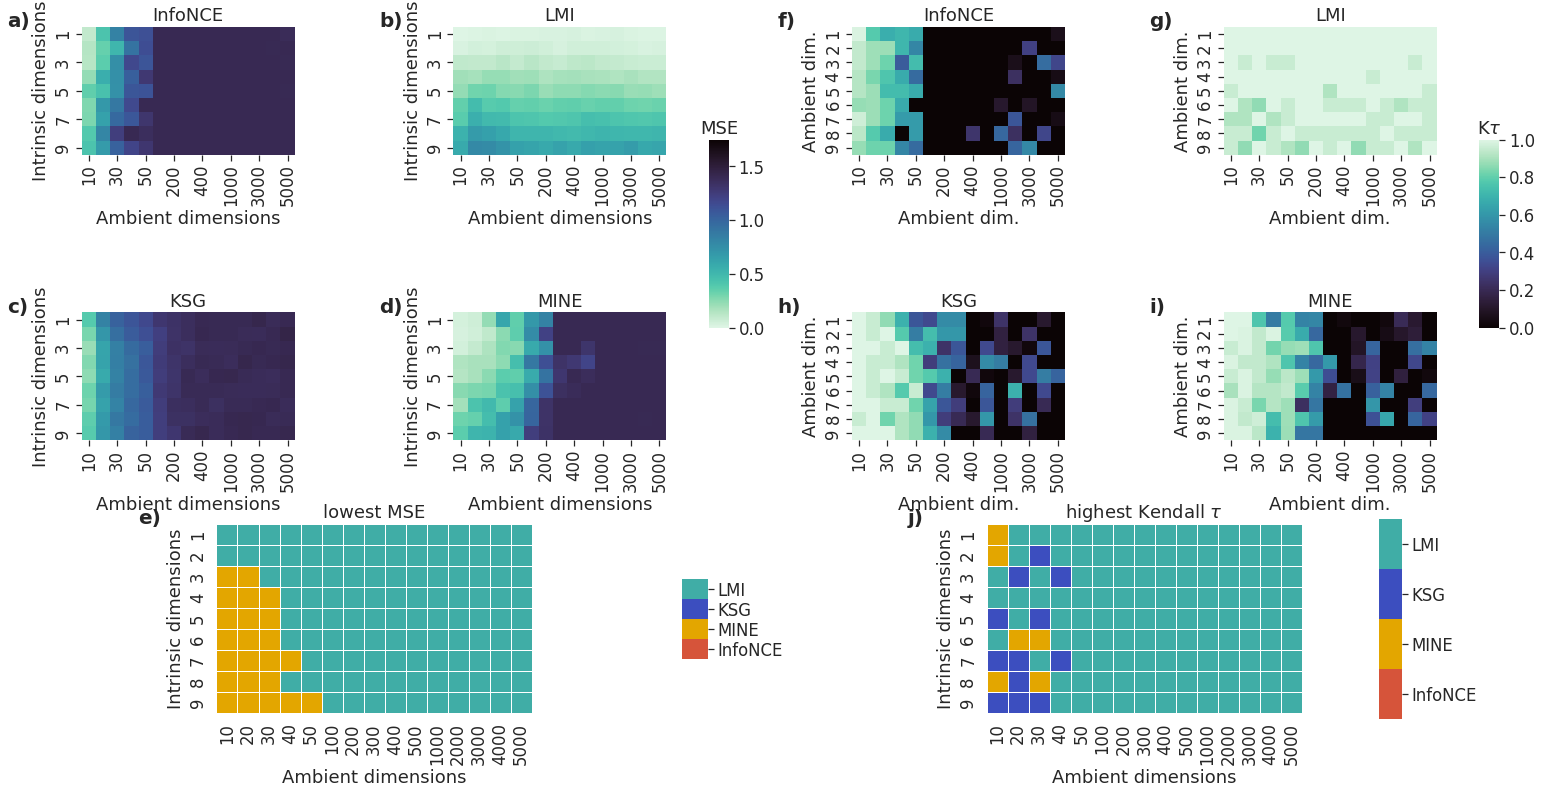

In [4]:
fig = plt.figure(figsize=(20, 10))

mse_half, kendall_half = fig.subfigures(1, 2, wspace=.15)

mse_vals, mse_bests = mse_half.subfigures(2, 1, hspace=.15, 
                                          height_ratios=(2.35,1))

kendall_vals, kendall_bests = kendall_half.subfigures(2, 1, hspace=.15, 
                                          height_ratios=(2.35,1))
sns.set(font_scale=1.5)
###################################
###### MSE values 4 heatmaps ######
###################################

axn = mse_vals.subplots(2, 2)
cbar_ax = mse_vals.add_axes([.95, .3, .03, .4])

k = g4.apply(mse).unstack().fillna(0)
ests = list(set(df4['Estimator']))
letters = ['a)', 'b)', 'c)', 'd)']
for i, ax in enumerate(axn.flat):
    sns.heatmap(k.reset_index().pivot_table(columns='Ambient dimensions',
                            index='Intrinsic dimensions',
                            values=ests[i]), square=True, cmap='mako_r',
                ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1.75, #linewidth=0.05,
                cbar_ax=None if i else cbar_ax)
    if not i:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_title('MSE')
        
    ax.set_title(ests[i])
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    letter_annotation(ax, -.35, 1, letters[i])

fig.tight_layout(rect=[0, 0, .9, 1])


###############################
###### MSE bests heatmap ######
###############################

value_to_int = {j:i for i,j in enumerate(pd.unique(df4['Estimator'].values.ravel()))}
value_to_int
n = len(value_to_int)     

bests = k.melt(ignore_index=False).reset_index().sort_values(
    'value').drop_duplicates(['Intrinsic dimensions', 'Ambient dimensions'], keep='first')
bests = bests.replace(value_to_int).pivot_table(index='Intrinsic dimensions',
                                                 columns='Ambient dimensions',
                                                 values='Estimator')

ax = mse_bests.subplots(1)
sns.heatmap(bests, cmap=c4[::-1], square=True, 
                 linewidth=0.5, vmin=0, ax=ax, 
            cbar_ax=mse_bests.add_axes([.91, .3, .038, .4])) 


colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))

ax.set_title('lowest MSE')
letter_annotation(ax, -0.25, 1, 'e)')


############################
###### Kendall values ######
############################

axn = kendall_vals.subplots(2, 2)
cbar_ax = kendall_vals.add_axes([.95, .3, .03, .4])

k = g4.apply(kendall).unstack().fillna(0)
ests = list(set(df4['Estimator']))
letters = ['f)', 'g)', 'h)', 'i)']
for i, ax in enumerate(axn.flat):
    sns.heatmap(k.reset_index().pivot_table(columns='Ambient dimensions',
                            index='Intrinsic dimensions',
                            values=ests[i]), square=True, cmap='mako',
                ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1, #linewidth=0.05,
                cbar_ax=None if i else cbar_ax)
    if not i:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_title('K$\\tau$')
        
    ax.set_title(ests[i])
    ax.set_xlabel('Ambient dim.')
    ax.set_ylabel('Ambient dim.')
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    letter_annotation(ax, -.35, 1, letters[i])

fig.tight_layout(rect=[0, 0, .9, 1])


###########################
###### Kendall bests ######
###########################   

bests = k.melt(ignore_index=False).reset_index().sort_values(
    'value').drop_duplicates(['Intrinsic dimensions', 'Ambient dimensions'], keep='last')
bests = bests.replace(value_to_int).pivot_table(index='Intrinsic dimensions',
                                                 columns='Ambient dimensions',
                                                 values='Estimator')

ax = kendall_bests.subplots(1)
sns.heatmap(bests, cmap=c4[::-1], square=True, 
                 linewidth=0.5, vmin=0, ax=ax, 
            cbar_ax=kendall_bests.add_axes([.8, .0, .035, 1])) 


colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))

ax.set_title('highest Kendall $\\tau$')
letter_annotation(ax, -0.25, 1, 'j)')